# <center>**ANEXO A PRÁCTICA DE BASES DE DATOS VECTORIALES**</center>

## **ÍNDICE**

**1. Introducción**

**2. Conversión de texto a** ***embeddings.***
- **2.1. Ejercicio:** conversión de **texto simple**.
- **2.2. RAG** con **<code>LangChain</code>** y **<code>ChromaDB</code>**.
    - **2.2.1.** Conozca **<code>LangChain & ChromaDB</code>.**
    - **2.2.2. Ejercicio:** implementación de una aplicación ***Retrieval-Augmented Generation.***

**3. Conversión de imágenes a** ***embeddings.***
- **3.1. Ejercicio:** convierta el popular dataset de **imágenes MNIST** en una base de datos vectorial.

## **2. Conversión de texto a *embeddings.***

**RAG (Retrieval-Augmented Generation)** es una técnica que combina el poder de los modelos de lenguaje generativos, como GPT, con los de los ***modelos de recuperación de información*** de bases de datos o fuentes de conocimiento externas. La idea principal es utilizar un sistema de recuperación para obtener datos relevantes de una base de conocimiento y luego usar un ***modelo de lenguaje*** para generar respuestas o contenidos basados en la información recuperada.

**Ventajas** de esta combinación:
- **Respuestas más precisas**: el sistema no depende solo de la generación probabilística del modelo, sino que usa información relevante para aumentar la precisión.
- **Respuestas especializadas**: el sistema se puede basar en información de un dominio específico.
- **Datos actualizados**: es posible tener bases de datos actualizadas para proporcionar respuestas con información actualizada a tiempo real.
- **Aplicaciones complejas**: con **<code>LangChain</code>**, se puede combinar esta capacidad con otras fuentes de datos o flujos de trabajo complejos (APIs, bases de datos adicionales).

### **2.2. RAG** con **<code>LangChain</code>** y **<code>ChromaDB</code>**.

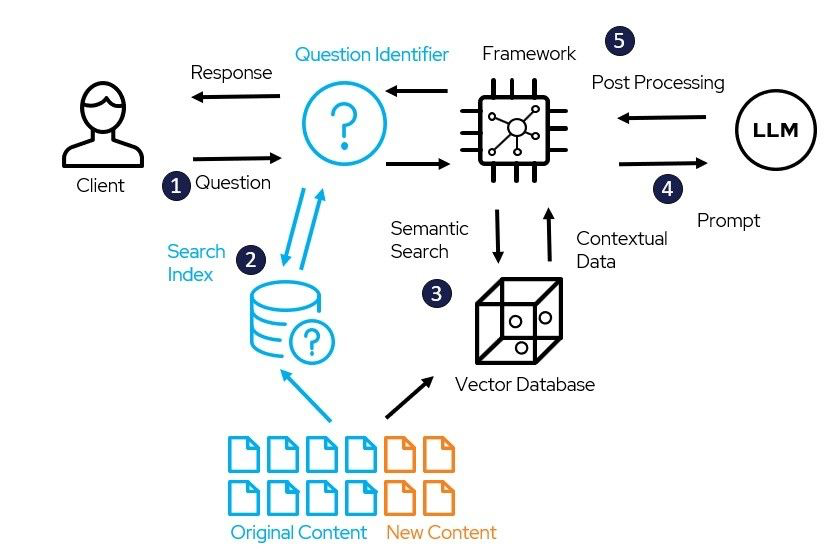

#### **2.2.1.** Conozca **<code>LangChain & ChromaDB</code>.**

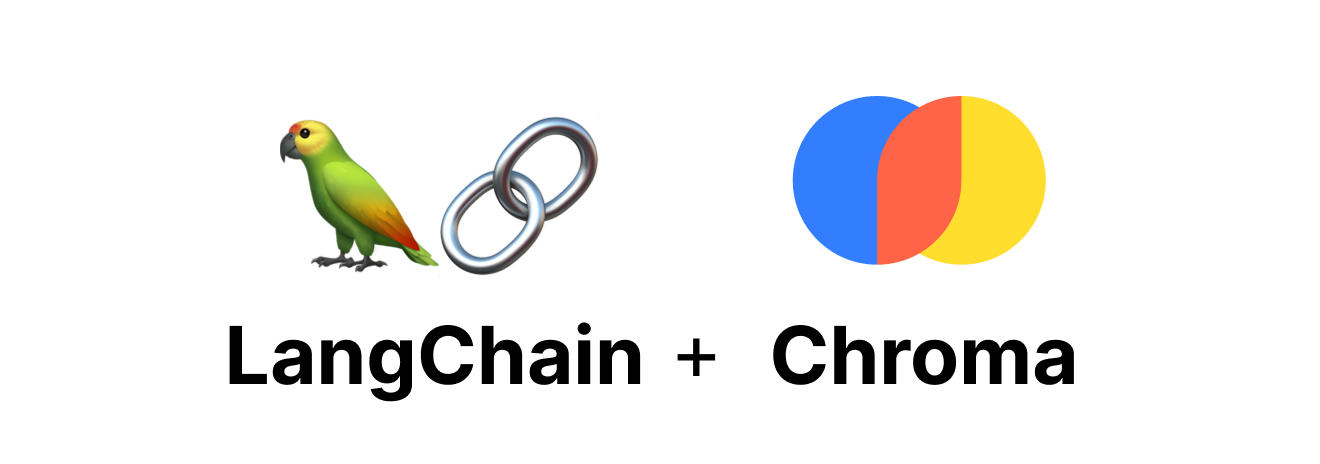

**<code>ChromaDB</code>** es una **base de datos vectorial** que permite almacenar, indexar y recuperar vectores. Como se ha visto anteriormente, la inforamción relativa a texto, imágenes u otros datos, puede ser expresada en forma de representaciones vectoriales numéricas (*embeddings*), generadas por modelos de **inteligencia artificial**, como los **modelos de lenguaje.**

**<code>LangChain</code>** es un framework desarrollado para construir aplicaciones con modelos de lenguaje que integran otras herramientas, en concreto, se actúa como un **orquestador**, sirviendo de enlace entre los modelos de lenguaje y otros elementos como:

1. **Bases de datos**.
2. **APIs externas**.
3. **Sistemas de recuperación de información**.

El flujo de una aplicación **RAG con **<code>LangChain</code>** y **<code>ChromaDB</code>**** sería el siguiente:

1. **Ingreso de pregunta**: el usuario formula una pregunta.
2. **Conversión de la consulta a vector** ***(embeddings)***: la pregunta se vectoriza mediante un modelo de embeddings.
4. **Búsqueda en <code>ChromaDB</code>**: se compara el vector de la pregunta con los vectores almacenados en la base de datos de la aplicación, la cual se contruido como resultado de la vectorización de **documentos provenientes de fuentes externas**.
5. **Recuperación de documentos relevantes**: <code>ChromaDB</code> devuelve los documentos más relevantes en base a la **similitud con los vectores de búsqueda**.
6. **Generación de respuesta**: el **LLM** genera una respuesta utilizando la información recuperada.


**<code>LangChain</code>** permite **integrar** todo este flujo encargándose de:
   - Orquestar el proceso de **transformación de texto a vectores**: integra el modelo de embeddings (preentrenado como GPT o HuggingFace, u otros) que vectoriza la consulta.
   - **Conectar el modelo de lenguaje con <code>ChromaDB</code>**.
   - **Gestionar la recuperación de información de <code>ChromaDB</code> y la generación final de texto por el LLM:** coordina el flujo entre los datos recuperados y el modelo de lenguaje para que este último pueda crear una respuesta utilizando los documentos relevantes.

***En esencia, <code>LangChain</code> permite conectar, coordinar y automatizar todo el flujo RAG de manera eficiente y escalable.***

#### **2.2.2. Ejercicio:** implementación de una aplicación ***Retrieval-Augmented Generation.***

En esta práctica se derrollará un **Corrective RAG**, que se diferencia de un **RAG** en que, si bien los **RAG** potencian la entrada de los modelos generativos, los **corrective RAG** actuan sobre la salida de los mismos, buscando mejorar o corregir la respuesta del modelo.

**Diferencia**
1. **RAG (Retrieval-Augmented Generation):**
   - Combina dos procesos: **recuperación** y **generación**.
   - El modelo recupera información relevante de una base de datos o fuentes externas antes de generar una respuesta, lo que mejora su precisión al basarse en datos actualizados o más confiables.
   - Se usa para enriquecer las respuestas del modelo con datos verificados o especializados.

2. **Corrective RAG:**
   - Se enfoca en **corregir** las respuestas que el modelo ya ha generado.
   - Funciona como una capa adicional donde, tras generar una respuesta inicial, el sistema busca información externa para verificar o corregir errores potenciales.
   - En lugar de asistir desde el inicio de la generación, actúa como un filtro correctivo posterior.

*Para esta práctica, se seguirá el guión del siguiente [artículo](https://medium.com/the-ai-forum/implementing-a-flavor-of-corrective-rag-using-langchain-chromadb-zephyr-7b-beta-and-openai-30d63e222563).*

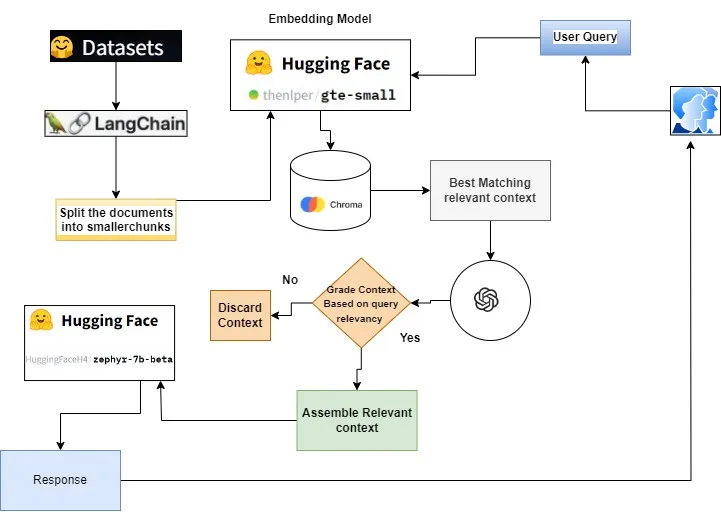

**Parte 1 - Descarga y conformación de la base de datos**
-----------------------------------------------------

In [ ]:
#pip install transformers accelerate bitsandbytes langchain sentence-transformers chromadb openpyxl ragatouille langchain_openai datasets langchain-community

##### **1. Importación de las librerías básicas.**

In [ ]:
import os
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import datasets
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)

##### **2. Descarga de la fuente de datos externa.**

Los sistemas RAG comienzan con la creación de una base de datos vectorial, a partir de una fuente de datos externa. Esta base de datos servirá en el futuro para enriquecer las consultas al modelo de lenguaje.

Para esta práctica, se utilizará el dataset de HuggingFace [m-ric/huggingface_doc](https://huggingface.co/datasets/m-ric/huggingface_doc).

In [ ]:
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [ ]:
print(ds[0]['text'][:140])

 Create an Endpoint

After your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). 


##### **3. Formateo del texto al esquema de <code>LangChain</code>.**

<code>LangChain</code> tiene una esquema de datos propio que permite que la información, junto con sus metadatos, sean fácil y eficientemente gestionados por las aplicaciones que los van a utilizar. En <code>LangChain</code> un documento es esencialmente una estructura de datos que consiste en dos componentes clave:

* **<code>page_content</code>:**
    * **Descripción:** El texto principal o el contenido del documento.
    * **Tipo:** *string*.
    * **Ejemplo:**

```
page_content = "Ejemplo de texto."

```

* **<code>metadata</code>:**
    * **Descripción:** (*opcional*) información sobre el documento (autor, fuente, fecha...), es útil para filtrar, buscar y organizar la información.
    * **Tipo:** *dict* que almacena pares clave-valor.
    * **Ejemplo:**

```
metadata = {
  "source": "Hugging Face dataset",
  "author": "Ric",
  "date": "2023-09-22",
  "section": "Introducción"
}

```

En <code>LangChain</code>, cada fila o entrada de un documento, debería de ser formateada a un objeto <code>Document</code>. Un **ejemplo de documento**, sería:

```
document = Document(
    page_content= "Texto del documento",
    metadata={
        "source": "m-ric/huggingface_doc",
        "split": "train",
        "dataset": "huggingface_doc",
        "author": "Ric"
    }
)

```

In [ ]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]
print('\nLongitud:', len(RAW_KNOWLEDGE_BASE), '\n')
print('Contenido del documento: \n', RAW_KNOWLEDGE_BASE[1].page_content[:140], '...', '\n') # se imprimen los primeros 140 caractéres
print('Metadatos del documento: \n',RAW_KNOWLEDGE_BASE[1].metadata)

  0%|          | 0/2647 [00:00<?, ?it/s]


Longitud: 2647 

Contenido del documento: 
  Choosing a metric for your task

**So you've trained your model and want to see how well it’s doing on a dataset of your choice. Where do y ... 

Metadatos del documento: 
 {'source': 'huggingface/evaluate/blob/main/docs/source/choosing_a_metric.mdx'}


##### **4. Fragmentación del texto -** ***Chunking.***

Para facilitar el manejo y la gestión de grandes cantidades de texto, se recurre a la fragmentación del mismo, lo que se denomina ***chunking.***

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Se utiliza una lista jerárquica de separadores diseñada para dividir documentos Markdown,
# tomada de la clase LangChain's MarkdownTextSplitter.
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # número máximo de caractéres por chunk - arbitrario.
    chunk_overlap=100,      # número de caractéres que se pueden solapar por chunks.
    add_start_index=True,   # If `True`, incluye el índice de inicio del fragmento en los metadatos.
    strip_whitespace=True,  # If `True`, elimina los espacios en blanco desde el principio y el final de cada documento.
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

##### **5. Configuración del modelo de incrustación** ***(embedding).***

En este paso, se deberá configurar un nodelo, habitualmente pre-entrenado, que convierta la información de nuestra fuente externa a un conjunto de vectores. Es importante asegurarse de que el parámetro <code>max_seq_length</code> (tamaño máximo aceptado de la secuencia de caracteres) del modelo utilizado, admita un número tan grande como el <code>chunk_size</code> utilizado durante el proceso de *chunking*, de lo contrario, la salida será truncada, y será necesario cambiar de modelo, o repetir la fragmentación definiendo una longitud de caractéres por *chunk* menor.

Longitud de la secuencia máxima del modelo: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

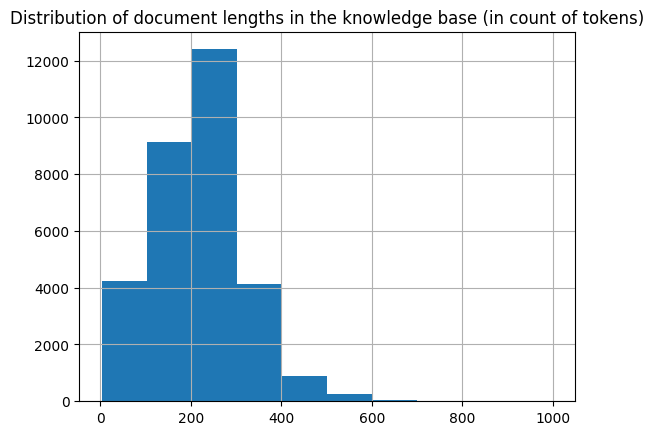

In [ ]:
from sentence_transformers import SentenceTransformer

# Para consultar la max sequence_length que tiene el modelo, se puede consultar el objeto SentenceTransformer utilizado en SentenceTransformer
print(f"Longitud de la secuencia máxima del modelo: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Distribución del número de tokens (longitud) de los documentos
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

Tal y como se observa en el gráfico, algunos documentos superan el límite de 512 tokens, por lo que si sigue adelante con esta configuración, algunos elementos serán truncados y se perderán.

Esto es un problema habitual cuando se utiliza **conteo por caracteres** para delimitar el tamaño de los fragmentos (*chunks*), en vez de **conteo por tokes**, pues el conteo por caracteres es menos preciso en el contexto del procesamiento de texto, dado que los caracteres no tienen una relación directa con la longitud de los tokens de los LLM.

Por lo tanto, se debería reconfigurar el *chunking* cambiando los parámetros de la clase <code>RecursiveCharacterTextSplitter</code>, para que el **conteo se realice por tokens** (habrá que cambiar el ***tokenizador***), y fijando el **<code>chunk_size</code>** a menos de 512. El problema de esta nueva configuración es que, si bien fragmentos pequeños pueden ayudar a que el modelo se centre en ideas muy concretas, fragmentos demasiado pequeños podrían llegar a perder el significado.

El tokenizador que se utilizará será el de *Hugging Face*. Los tokens podrán ser palabras completas, subpalabras o incluso símbolos, dependiendo del tokenizador utilizado.

In [ ]:
#from langchain.text_splitter import RecursiveCharacterTextSplitter
#from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"
chunk_size = 512

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
  docs_processed += text_splitter.split_documents([doc])

print(len(docs_processed))#19983

19983


A continuación, visualice la nueva distribución de longitud.

  0%|          | 0/19983 [00:00<?, ?it/s]

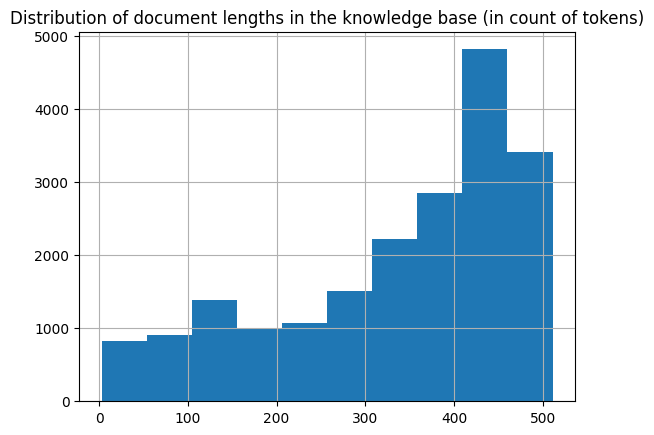

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

##### **6. Configuración de la base de datos vectorial.**

Almacenamiento de la información externa, que ya ha sido vectorizada y fragmentada, en una base de datos vectorial utilizando <code>ChromaDB</code>.

In [ ]:
# SI ES LA PRIMERA VEZ QUE EJECUTA EL CUADERNO, DEBERÁ GENERAR LA BASE DE DATOS, DE LO CONTRARIO, PODRÁ OMITIR ESTA CELDA

from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

# Deshabilitar la paralelización de tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Construcción de la base de datos
try: mkdir= 'CRAG DatabaseV'
except: pass

directory= os.path.join (os.getcwd(), 'CRAG DatabaseV')

# Crear un modelo de embeddings utilizando la clase HuggingFaceEmbeddings.
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,               # Nombre del modelo preentrenado que se utilizará para generar embeddings.
    multi_process=True,                            # Habilitar procesamiento en múltiples procesos para acelerar la generación de embeddings.
    model_kwargs={"device": "mps"},                # Especificar el dispositivo para ejecutar el modelo (CPU, GPU, mps - procesador M)
    encode_kwargs={"normalize_embeddings": True},  # Normalizar los embeddings para que tengan magnitud 1, útil para la similitud coseno.
)

# Crear una base de datos de vectores (Chroma) a partir de documentos procesados.
KNOWLEDGE_VECTOR_DATABASE = Chroma.from_documents(
    docs_processed,                                # Lista de documentos procesados que se utilizarán para crear los embeddings.
    embedding_model,                               # El modelo de embeddings creado anteriormente.
    persist_directory=directory,                   # Directorio donde se persistirá la base de datos de vectores.
    collection_name="crag"                         # Nombre de la colección en la base de datos de vectores.
)

# Que la base de datos de vectores persista en el directorio especificado.
KNOWLEDGE_VECTOR_DATABASE.persist()

# Imprimir el número de documentos almacenados.
print(len(KNOWLEDGE_VECTOR_DATABASE.get()['documents']))

/var/folders/t0/3l3y4kj50jg8rx93l81wdb6m0000gn/T/ipykernel_6084/3243524203.py:31: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  KNOWLEDGE_VECTOR_DATABASE.persist()


19983


**Parte 2 - Configuración del modelo y ensamblado de los pipelines**
----------------------------------------------------------------

In [ ]:
#pip install transformers accelerate bitsandbytes langchain sentence-transformers chromadb openpyxl ragatouille langchain_openai datasets langchain-community

In [2]:
# En caso de utilizarse GPU de Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# UNA VEZ EJECUTADO EL CUADERNO POR PRIMERA VEZ, PODRÁ CARGAR LA BASE DE DATOS SIN VOLVER A GENERARLA CON ESTE CÓDIGO
import os
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

# Deshabilitar la paralelización de tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

EMBEDDING_MODEL_NAME = "thenlper/gte-small"
directory= os.path.join (os.getcwd(), 'CRAG DatabaseV')

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},
)

KNOWLEDGE_VECTOR_DATABASE= Chroma(collection_name='crag', embedding_function=embedding_model, persist_directory=directory)

# Imprimir el número de documentos almacenados.
print(len(KNOWLEDGE_VECTOR_DATABASE.get()['documents']))

<ipython-input-7-0799c4b0deeb>:20: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  KNOWLEDGE_VECTOR_DATABASE= Chroma(collection_name='crag', embedding_function=embedding_model, persist_directory=directory)


19983


Realice una consulta a la base de datos, y compruebe los datos que devuelve dicha consulta.

In [8]:
query = "How to create a pipeline object?"

print(f"\nBuscando documentos con similitud a la {query = }...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=query, k=5)

print("\n==================================Top document==================================")
print(retrieved_docs[1].page_content)

print("==================================Metadata==================================")
print(retrieved_docs[1].metadata)


Buscando documentos con similitud a la query = 'How to create a pipeline object?'...

==================================Top document==================================
```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).

</Tip>
==================================Metadata==================================
{'source': 'huggingface/transformers/blob/main/docs/source/en/quicktour.md', 'start_index': 1585}


##### **7. Configuración del LLM.**

En este paso, se creará el ***pipeline*** **para la generación de texto ante una** ***query***. Para ello habrá que definir:

1. El **LLM que generará el texto**, en nuestro ejemplo <code>HuggingFaceH4/zephyr-7b-beta</code>.
2. El **tokenizador que convertirá texto a tokens**, y vicerversa, en nuestro ejemplo será el propio de <code>HuggingFaceH4/zephyr-7b-beta</code>.
3. La **cuantización del modelo**, es decir, la precisión del mismo, pues con el fin de reducir los requerimientos computacionales se puede reducir su precisión.

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import pipeline
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline

# Se define el nombre del modelo que se va a utilizar de Hugging Face.
READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

# Configuración de la cuantización utilizando BitsAndBytes (reducción de la precisión para reducir coste computacional).
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Cargar el modelo en precisión de 4 bits.
    bnb_4bit_use_double_quant=True,         # Usar doble cuantización.
    bnb_4bit_quant_type="nf4",              # Tipo de cuantización (nf4 es un método específico).
    bnb_4bit_compute_dtype=torch.bfloat16,  # Tipo de dato para cálculos, aquí usamos bfloat16.
)

# Cargar el LLM preentrenado definido previamente, para la generación de texto, con la configuración descrita.
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)

# Cargar el tokenizador asociado al modelo preentrenado.
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [10]:
# Creación de un pipeline para generación de texto.
from transformers import pipeline

READER_LLM = pipeline(
    model=model,             # El modelo cargado previamente.
    tokenizer=tokenizer,     # El tokenizador cargado previamente.
    task="text-generation",  # Especificamos que la tarea es generación de texto.
    do_sample=True,          # Habilitar muestreo para la generación (en lugar de la selección determinista - siempre la más probable).
    temperature=0.2,         # Controla la aleatoriedad de las predicciones (valores más bajos son menos aleatorios).
    repetition_penalty=1.1,  # Penaliza las repeticiones en la generación de texto.
    return_full_text=False,  # Indica si se debe devolver el texto completo o solo la parte nueva generada.
    max_new_tokens=500,      # Número máximo de nuevos tokens a generar en la respuesta.
)

# Creación de una instancia de HuggingFacePipeline utilizando el pipeline de generación de texto.
llm = HuggingFacePipeline(pipeline=READER_LLM)

<ipython-input-10-c7b7e7403adf>:16: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=READER_LLM)


Cree un ***prompt*** de ejemplo.

In [11]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]


RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



**Extraiga los textos de los documentos similares en base a los prompts conformados.**

In [12]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How to create a pipeline object?", context=context)

print(final_prompt)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:

Extracted documents:
Document 0:::
```

## Available Pipelines:Document 1:::
```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).

</Tip>Document 2:::
```

2. Pass a prompt to the pipeline to generate an image:

```py
image = pipeline(
	"stained glass of darth vader, backlight, centered composi

**Sintetice la respuesta.**

In [13]:
from langchain_core.output_parsers import JsonOutputParser
answer = llm(final_prompt)
print(answer)

<ipython-input-13-0e31a2f7b72f>:2: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  answer = llm(final_prompt)


To create a pipeline object, you can follow these steps based on the provided context:

1. Choose the task you want to perform, such as sentiment analysis, image generation, or text classification.
2. Identify the appropriate pipeline function from the available pipelines listed in Document 1. For example, for sentiment analysis, you can use `pipeline("sentiment")`.
3. Pass your input data to the pipeline function, following the expected format. For instance, for text classification, you can pass a string as the argument, like `pipeline("This is a positive review.")`. For image generation, you can provide a prompt as the argument, such as `pipeline("A beautiful sunset over the ocean.")`.
4. Access the resulting predictions using the `images` or `labels` attribute of the returned pipeline object, depending on the task.

Here's an example code snippet based on the provided context:

```python
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers.pip

**8.** ***Reranking***

Una buena opción en los RAGs, es establecer un ranking de los documentos devueltos, quedándose finalmente con los primeros k de ellos.

In [14]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

print("=> Reranking documents...")
question = "How to create a pipeline object?"

relevant_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=question, k=5)
relevant_docs = [doc.page_content for doc in relevant_docs]
reranked_relevant_docs = RERANKER.rerank(question, relevant_docs, k=3)

reranked_docs = [doc["content"] for doc in reranked_relevant_docs]

# Compare the documents retrived for normal vector search and rereanker
for i,doc in enumerate(relevant_docs[:3]):
    print(f"Document {i}: {doc}")
    print("="*80)

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

=> Reranking documents...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

Document 0: ```

## Available Pipelines:
Document 1: ```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).

</Tip>
Document 2: ```

2. Pass a prompt to the pipeline to generate an image:

```py
image = pipeline(
	"stained glass of darth vader, backlight, centered composition, masterpiece, photorealistic, 8k"
).images[0]
image


**Repetir el prompt con rankeo.**

In [15]:
retrieved_docs_text = [doc for doc in reranked_docs]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How to create a pipeline object?", context=context)

print(final_prompt)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:

Extracted documents:
Document 0:::
```

2. Pass a prompt to the pipeline to generate an image:

```py
image = pipeline(
	"stained glass of darth vader, backlight, centered composition, masterpiece, photorealistic, 8k"
).images[0]
imageDocument 1:::
```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipel

**Sintesis de la respuesta obtenida.**

In [16]:
answer = llm(final_prompt)
print(answer)

To create a pipeline object, you can follow these steps:

1. Import the necessary modules from TensorFlow Hub:

   ```python
   import tensorflow as tf
   from tensorflow_hub import KerasLayer
   ```

2. Load the pretrained model from TensorFlow Hub using the `load()` method:

   ```python
   hub_handle = "google/dreambooth_v1_512x512"
   layer = KerasLayer(handle=hub_handle, input_shape=(None, None, 3))
   ```

3. Create a pipeline object by passing a string containing the desired task and any additional prompts to the `Pipeline` constructor:

   ```python
   pipeline = tf.keras.Sequential([layer])
   pipeline("stained glass of darth vader, backlight, centered composition, masterpiece, photorealistic, 8k")
   ```

4. Generate an image by passing the pipeline object a string containing the desired task and any additional prompts:

   ```python
   image = pipeline("stained glass of darth vader, backlight, centered composition, masterpiece, photorealistic, 8k").images[0]
   ```

That's i

Como de puede observar, la respuesta es ahora mucho más precisa.

**9. Implementación del** ***Corrective RAG***

In [ ]:
from langchain_openai import OpenAI
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

llm_openai = OpenAI(temperature=0)
#
c_prompt =  PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keywords related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide only the binary score as a text varible with a single key 'score' and no premable or explaination.""",
        input_variables=["question", "context"],
    )
#

score_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keywords related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n"""
#

In [18]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain.prompts import PromptTemplate

response_schemas = [
    ResponseSchema(name="Score", description="score for the context query relevancy"),
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
#
format_instructions = output_parser.get_format_instructions()
#
print(output_parser)
#
print(format_instructions)

response_schemas=[ResponseSchema(name='Score', description='score for the context query relevancy', type='string')]
The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"Score": string  // score for the context query relevancy
}
```


In [ ]:
template=score_prompt+"\n{format_instructions}"
print(template)
#
scoreprompt = PromptTemplate.from_template(template=template)
print(f"scoreprompt : {scoreprompt}")

**Prueba con el prompt final.**

In [ ]:
question = "How to create a pipeline object?"
context = reranked_docs[0]
final_prompt = scoreprompt.format_prompt(format_instructions=format_instructions,
                                   question=question,
                                    context=context,
                                    ).text
print(final_prompt)